<a href="https://colab.research.google.com/github/Dewanou/test_stock_scoring/blob/main/EDABacktestingNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Installer les dépendances (exécuter en Colab)
!pip install --quiet yfinance pandas numpy matplotlib seaborn requests beautifulsoup4 lxml fredapi


In [4]:
# Notebook A — Data Preparation
#Objectif : récupérer un univers >200 tickers, télécharger les prix OHLC (2005→aujourd'hui), effectuer des vérifications qualité, et construire un feature store parquet.


In [6]:
# Récupérer listes de tickers depuis Wikipedia (S&P500, FTSE100). Colab required.
import requests, pandas as pd
from bs4 import BeautifulSoup

def wiki_table(url, table_index=0):
    # Add a User-Agent header to mimic a web browser and avoid 403 Forbidden errors
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    r = requests.get(url, headers=headers)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, 'lxml')
    tables = soup.find_all('table', {'class':'wikitable'})
    return pd.read_html(str(tables[table_index]))[0]

# S&P500
sp500 = wiki_table('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_tickers = sp500['Symbol'].astype(str).str.replace('.', '-').tolist()

# FTSE 100
ftse = wiki_table('https://en.wikipedia.org/wiki/FTSE_100')
# heuristic: find a column with EPIC/ticker-style entries
ftse_tickers = []
for col in ftse.columns:
    vals = ftse[col].astype(str).str.strip()
    cand = vals[vals.str.match(r'^[A-Z\\.]{1,6}$', na=False)]
    if len(cand)>0:
        ftse_tickers = [v + '.L' for v in cand.tolist()]
        break

# Optionnel : CAC40 scraping (ou upload CSV)
# Combine
universe = list(dict.fromkeys(sp500_tickers + ftse_tickers))
len(universe), universe[:10]

/tmp/ipython-input-2881102053.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  return pd.read_html(str(tables[table_index]))[0]
/tmp/ipython-input-2881102053.py:12: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  return pd.read_html(str(tables[table_index]))[0]


(506, ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A'])

In [11]:
#Notes :
#- On standardise '.' → '-' car Yahoo Finance remplace '.' par '-' pour certains tickers (ex: BRK.B → BRK-B).
#- On limite à MAX_TICKERS (ex: 250) pour prototype.
# Téléchargement OHLC ajusté par batch avec yfinance
import yfinance as yf
import os, time
import pandas as pd

os.makedirs('data/prices', exist_ok=True)
MAX_TICKERS = 500
BATCH = 50
start = '2005-01-01'

universe = universe[:MAX_TICKERS]

for i in range(0, len(universe), BATCH):
    batch = universe[i:i+BATCH]
    print(f"Downloading batch {i} -> {i+len(batch)-1}")
    df = yf.download(batch, start=start, group_by='ticker', auto_adjust=True, threads=True)
    for t in batch:
        try:
            if isinstance(df.columns, pd.MultiIndex):
                df_t = df[t].dropna(how='all')
            else:
                df_t = df.dropna()
            if not df_t.empty:
                df_t.to_csv(f"data/prices/{t}_prices.csv")
        except Exception as e:
            print("Error", t, e)
    time.sleep(1)
print("Download finished.")


[*********************100%***********************]  50 of 50 completed


[*********************100%***********************]  50 of 50 completed


[*********************100%***********************]  50 of 50 completed


[*********************100%***********************]  50 of 50 completed


[*********************100%***********************]  50 of 50 completed
[                       0%                       ]

[*********************100%***********************]  50 of 50 completed


[*********************100%***********************]  50 of 50 completed


[*********************100%***********************]  50 of 50 completed


[*********************100%***********************]  50 of 50 completed


[*********************100%***********************]  50 of 50 completed


Download finished.


In [14]:
# Code (vérification & EDA minimal)
# Lister fichiers téléchargés et charger close prices en DataFrame
import glob
files = glob.glob('data/prices/*_prices.csv')
print('Found files:', len(files))

import pandas as pd
closes = {}
for f in files:
    t = f.split('/')[-1].split('_')[0]
    df = pd.read_csv(f, parse_dates=['Date'], index_col='Date')
    if 'Close' in df.columns:
        closes[t] = df['Close']
close = pd.DataFrame(closes).sort_index()
print("Close shape:", close.shape)
display(close.iloc[-5:,:6])


Found files: 500
Close shape: (5266, 500)


,MU,IP,HBAN,LW,WDC,SWKS
Date,,,,,,
2025-12-01,240.460007,39.189999,16.540001,59.500000,163.408600,65.830002
2025-12-02,239.490005,37.849998,16.559999,59.049999,159.861465,68.239998
2025-12-03,234.160004,39.220001,17.040001,60.490002,155.464996,69.370003
2025-12-04,226.649994,39.130001,17.100000,59.759998,161.000000,69.010002
2025-12-05,237.220001,39.060001,16.900000,59.700001,168.889999,69.320000


/tmp/ipython-input-3271923099.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = close.pct_change().dropna()


<Figure size 1200x400 with 0 Axes>

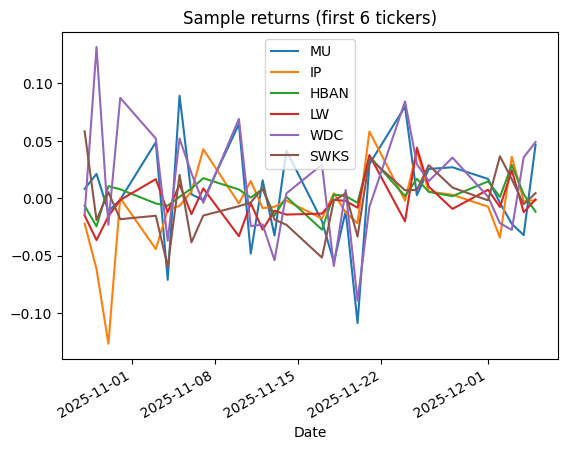

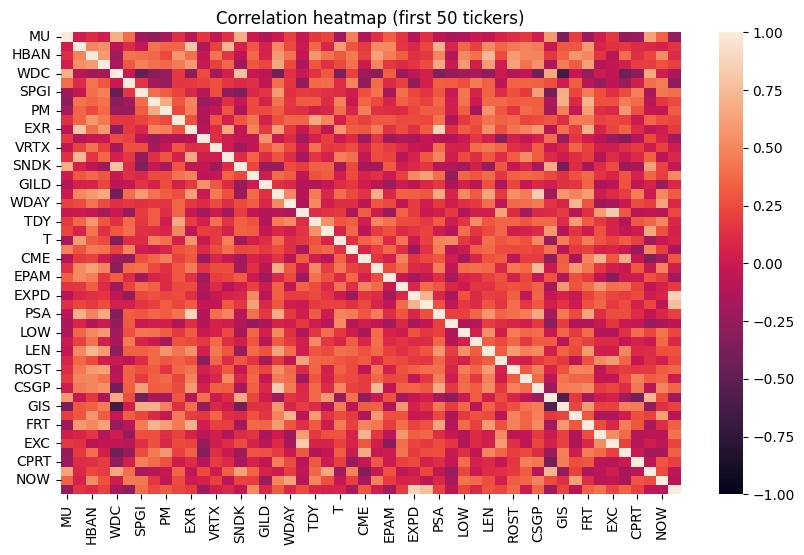

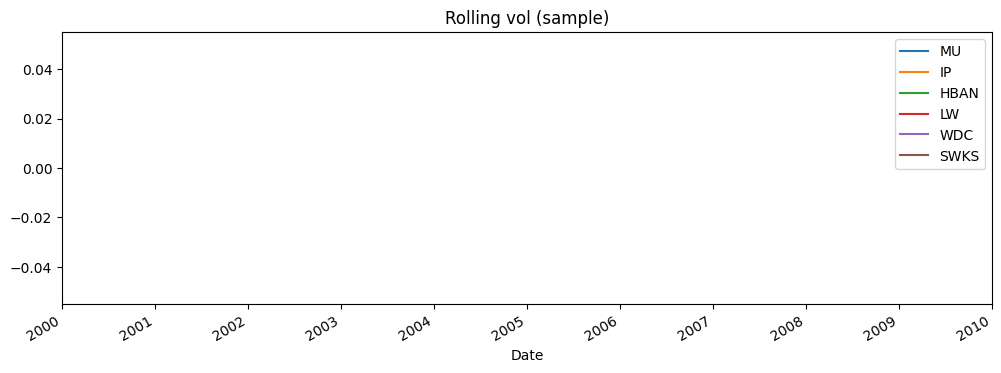

In [15]:
# EDA: returns distribution, rolling vol, correlation heatmap (sample)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rets = close.pct_change().dropna()
plt.figure(figsize=(12,4))
rets.iloc[:,:6].plot(subplots=False, title='Sample returns (first 6 tickers)')
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(rets.iloc[:,:50].corr(), vmin=-1, vmax=1)
plt.title('Correlation heatmap (first 50 tickers)')
plt.show()

# rolling vol
rolling_vol = rets.rolling(63).std() * (252**0.5)
rolling_vol.iloc[-200:,:6].plot(figsize=(12,4), title='Rolling vol (sample)')
plt.show()


In [16]:
# Feature engineering vectorisée et sauvegarde parquet
import numpy as np

def build_features(close):
    ret_1m = close.pct_change(periods=21)
    ret_3m = close.pct_change(periods=63)
    ret_6m = close.pct_change(periods=126)
    ret_12m = close.pct_change(periods=252)
    vol_1m = close.pct_change().rolling(21).std() * np.sqrt(252)
    vol_3m = close.pct_change().rolling(63).std() * np.sqrt(252)
    ma20 = close.rolling(20).mean()
    ma63 = close.rolling(63).mean()

    frames = []
    for ticker in close.columns:
        df = pd.DataFrame({
            'date': close.index,
            'ticker': ticker,
            'close': close[ticker],
            'ret_1m': ret_1m[ticker],
            'ret_3m': ret_3m[ticker],
            'ret_6m': ret_6m[ticker],
            'ret_12m': ret_12m[ticker],
            'vol_1m': vol_1m[ticker],
            'vol_3m': vol_3m[ticker],
            'ma20': ma20[ticker],
            'ma63': ma63[ticker]
        }).reset_index(drop=True)
        frames.append(df)
    feats = pd.concat(frames, ignore_index=True)
    feats['date'] = pd.to_datetime(feats['date'])
    feats = feats.set_index(['date','ticker']).sort_index()
    return feats

feats = build_features(close)
feats.to_parquet('data/features.parquet')
print("Saved features.parquet shape:", feats.shape)


/tmp/ipython-input-3204617898.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_1m = close.pct_change(periods=21)
/tmp/ipython-input-3204617898.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_3m = close.pct_change(periods=63)
/tmp/ipython-input-3204617898.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_6m = close.pct_change(periods=126)
/tmp/ipython-input-3204617898.py:

Saved features.parquet shape: (2633000, 9)


In [20]:
feats1 = pd.read_parquet('data/features.parquet')
feats

,date,ticker,close,ret_1m,ret_3m,ret_6m,ret_12m,vol_1m,vol_3m,ma20,ma63
0,2005-01-03,A,14.299248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2005-01-03,AAPL,0.949067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2005-01-03,ABBV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2005-01-03,ABNB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005-01-03,ABT,13.822743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2632995,2025-12-05,XEL,77.180000,-0.049390,0.084104,0.144821,0.123147,0.157610,0.195900,80.058500,78.961307
2632996,2025-12-05,XOM,116.540001,0.034125,0.070181,0.137942,0.026746,0.185235,0.176552,116.955289,113.957467
2632997,2025-12-05,XYL,139.009995,-0.074840,-0.004477,0.103487,0.101661,0.165421,0.163316,142.520708,144.571054
2632998,2025-12-05,XYZ,61.110001,-0.170265,-0.194012,-0.059701,-0.344313,0.568564,0.452434,62.769500,71.774444


In [17]:
import pandas as pd, numpy as np, glob, os
feats = pd.read_parquet('data/features.parquet').reset_index()
# load closes
files = glob.glob('data/prices/*_prices.csv')
closes = {}
for f in files:
    t = os.path.basename(f).split('_')[0]
    df = pd.read_csv(f, parse_dates=['Date'], index_col='Date')
    if 'Close' in df.columns:
        closes[t] = df['Close']
close = pd.DataFrame(closes).sort_index()
print('Features rows:', feats.shape[0], 'Close shape:', close.shape)


Features rows: 2633000 Close shape: (5266, 500)


In [21]:
H = 21
future_ret = close.pct_change(periods=H).shift(-H)
# benchmark: choose SPY if available else universe mean
if 'SPY' in close.columns:
    benchmark = future_ret['SPY']
else:
    benchmark = future_ret.mean(axis=1)

labels = (future_ret.sub(benchmark, axis=0) > 0).astype(int)
labels = labels.stack().rename('label').reset_index()  # columns: Date, level_1, label

# Rename 'level_1' to 'ticker'
labels = labels.rename(columns={'level_1':'ticker'})

# Convert 'Date' to datetime and assign to 'date' column for merging
labels['date'] = pd.to_datetime(labels['Date'])

# Merge with feats
feats = feats.merge(labels[['date','ticker','label']], on=['date','ticker'], how='left')
feats = feats.dropna(subset=['label']).copy()
feats['label'] = feats['label'].astype(int)
print('Prepared dataset rows:', feats.shape[0])

/tmp/ipython-input-508346573.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  future_ret = close.pct_change(periods=H).shift(-H)


Prepared dataset rows: 2633000


In [22]:
# Splitting dataframe
# numeric features selection
num_cols = feats.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != 'label']
X = feats[num_cols]
y = feats['label']

# create time-based split by unique dates (70/30)
unique_dates = sorted(feats['date'].unique())
split_date = unique_dates[int(len(unique_dates)*0.7)]
train_mask = feats['date'] <= split_date
X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[~train_mask], y[~train_mask]

print('Train rows:', X_train.shape[0], 'Test rows:', X_test.shape[0])


Train rows: 1843500 Test rows: 789500


In [23]:
#(scaler + LightGBM training)

from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import joblib

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train.fillna(0))
X_test_s = scaler.transform(X_test.fillna(0))

dtrain = lgb.Dataset(X_train_s, label=y_train)
params = {'objective':'binary','metric':'auc','verbosity':-1,'learning_rate':0.05,'num_leaves':31}
model = lgb.train(params, dtrain, num_boost_round=300)

preds = model.predict(X_test_s)
auc = roc_auc_score(y_test, preds)
print('Test AUC (approx):', auc)

# save artifacts
joblib.dump(model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print('Saved model.pkl and scaler.pkl')


Test AUC (approx): 0.5240273552789698
Saved model.pkl and scaler.pkl


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


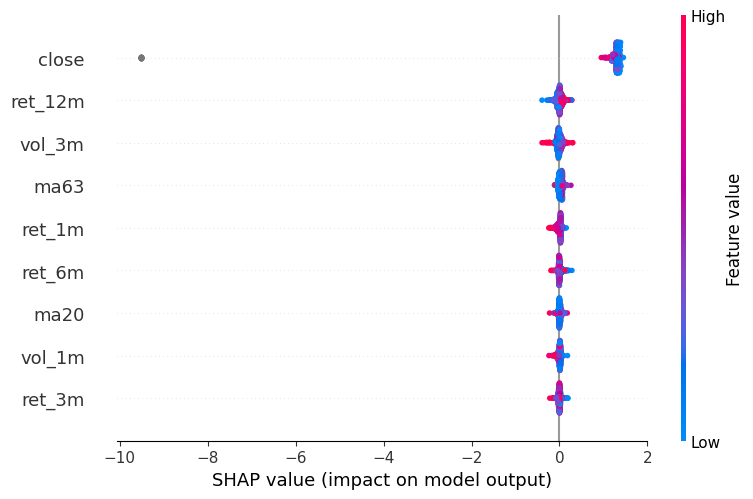

In [24]:
import shap
# utiliser sample pour réduire coût
sample_idx = np.random.choice(X_test.shape[0], size=min(1000, X_test.shape[0]), replace=False)
X_sample = X_test.iloc[sample_idx]
Xs = scaler.transform(X_sample.fillna(0))
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xs)
# plot summary (Colab will render)
shap.summary_plot(shap_values, X_sample, max_display=15)


In [25]:
# Generate scores for full dataset to use in backtest
X_all = X.fillna(0)
X_all_s = scaler.transform(X_all)
scores = model.predict(X_all_s)
feats['score'] = scores
scores_pivot = feats.pivot(index='date', columns='ticker', values='score')
scores_pivot.to_parquet('data/scores_pivot.parquet')
print('Saved scores_pivot.parquet shape:', scores_pivot.shape)


Saved scores_pivot.parquet shape: (5266, 500)


In [26]:
# Backtest simple: top-K equal weight, monthly rebalance, use prices
import pandas as pd, numpy as np
scores = pd.read_parquet('data/scores_pivot.parquet')
prices = close  # from earlier

rebalance_dates = scores.resample('M').first().index
K = 20
portfolio_rets = []
for d in rebalance_dates:
    if d not in scores.index:
        continue
    s = scores.loc[d].dropna()
    topk = s.nlargest(K).index.tolist()
    # next month start/end
    try:
        start = prices.index[prices.index>=d][0]
        end = prices.index[prices.index> (d + pd.Timedelta(days=28))][0]
    except Exception:
        continue
    rtns = prices.loc[end, topk] / prices.loc[start, topk] - 1
    portfolio_rets.append(rtns.mean())

pr = pd.Series(portfolio_rets)
if len(pr)>0:
    ann = (1+pr.mean())**12 -1
    print('Backtest periods:', len(pr), 'Approx ann return:', ann)
pr.to_csv('data/backtest_returns.csv', index=False)


/tmp/ipython-input-3478081866.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = scores.resample('M').first().index


Backtest periods: 178 Approx ann return: 0.7763201948757681


In [28]:
pr

,0
0,0.061685
1,0.025059
2,0.022559
3,0.029524
4,0.143742
...,...
173,0.094444
174,0.037687
175,0.018614
176,-0.035095


In [29]:
# Déploiement

In [30]:
!pip install --quiet fastapi uvicorn[standard] streamlit requests


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.7/517.7 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.8/456.8 kB 16.6 MB/s eta 0:00:00


In [31]:
import os, textwrap
os.makedirs('src/api', exist_ok=True)
api_code = textwrap.dedent('''\
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import pandas as pd

app = FastAPI()
model = joblib.load('model.pkl')
scaler = joblib.load('scaler.pkl')

class PredictRequest(BaseModel):
    features: dict

@app.get('/')
def health():
    return {'status':'ok'}

@app.post('/predict')
def predict(req: PredictRequest):
    X = pd.DataFrame([req.features])
    Xs = scaler.transform(X.fillna(0))
    prob = model.predict(Xs)[0]
    return {'probability': float(prob)}
''')
with open('src/api/main.py','w') as f:
    f.write(api_code)
print('Wrote src/api/main.py')


Wrote src/api/main.py


In [32]:
os.makedirs('src/web', exist_ok=True)
web_code = textwrap.dedent('''\
import streamlit as st
import requests
st.title("Stock Scoring Demo")

API_URL = st.text_input("API URL", "http://localhost:8000")
ticker = st.text_input("Ticker", "AAPL")
st.write("Ce UI est un template minimal. Pour usage réel, il doit charger features/historique pour afficher score et SHAP.")

if st.button("Get health"):
    try:
        r = requests.get(API_URL + "/")
        st.write(r.json())
    except Exception as e:
        st.write("Error:", e)
''')
with open('src/web/app.py','w') as f:
    f.write(web_code)
print('Wrote src/web/app.py')


Wrote src/web/app.py


In [33]:
reqs = """pandas
numpy
yfinance
lightgbm
scikit-learn
fastapi
uvicorn[standard]
streamlit
joblib
shap
requests
"""
with open('requirements.txt','w') as f:
    f.write(reqs)

docker_api = textwrap.dedent('''\
FROM python:3.11-slim
WORKDIR /app
COPY requirements.txt .
RUN pip install -r requirements.txt
COPY src/api ./src/api
COPY model.pkl ./model.pkl
COPY scaler.pkl ./scaler.pkl
CMD ["uvicorn", "src.api.main:app", "--host", "0.0.0.0", "--port", "8000"]
''')
with open('Dockerfile.api','w') as f:
    f.write(docker_api)

docker_web = textwrap.dedent('''\
FROM python:3.11-slim
WORKDIR /app
COPY requirements.txt .
RUN pip install -r requirements.txt
COPY src/web ./src/web
CMD ["streamlit", "run", "src/web/app.py", "--server.port=8501", "--server.address=0.0.0.0"]
''')
with open('Dockerfile.web','w') as f:
    f.write(docker_web)

docker_compose = textwrap.dedent('''\
version: '3.8'
services:
  api:
    build:
      context: .
      dockerfile: Dockerfile.api
    ports:
      - "8000:8000"
  web:
    build:
      context: .
      dockerfile: Dockerfile.web
    ports:
      - "8501:8501"
    depends_on:
      - api
''')
with open('docker-compose.yml','w') as f:
    f.write(docker_compose)

print("Wrote requirements.txt, Dockerfile.api, Dockerfile.web, docker-compose.yml")


Wrote requirements.txt, Dockerfile.api, Dockerfile.web, docker-compose.yml
